In [1]:
pip install numpy pandas matplotlib scikit-learn


  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
   ---------------------------------------- 0.0/307.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/307.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/307.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/307.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/307.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/307.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/307.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/307.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/307.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/307.7 kB ? eta -:--:--
   --- ------------------------------------ 30.7/307.7 kB 65.6 kB/s et


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


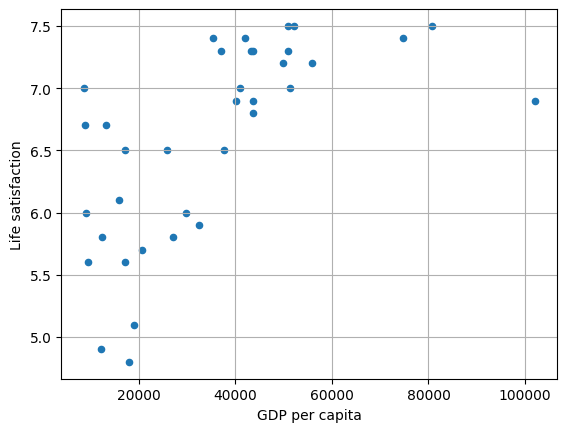

Predicted Life Satisfaction for Cyprus: [[6.28653637]]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

# Helper function to merge & clean data
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    return full_country_stats[["GDP per capita", "Life satisfaction"]]

# Load data
oecd_bli = pd.read_csv("oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv("gdp_per_capita.csv", thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize
country_stats.plot(kind='scatter', x="GDP per capita", y="Life satisfaction")
plt.grid(True)
plt.show()

# Train Linear Regression model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

# Predict
X_new = [[22587]]  # Cyprus GDP per capita
print("Predicted Life Satisfaction for Cyprus:", model.predict(X_new))


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error


In [4]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
df = housing.frame


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


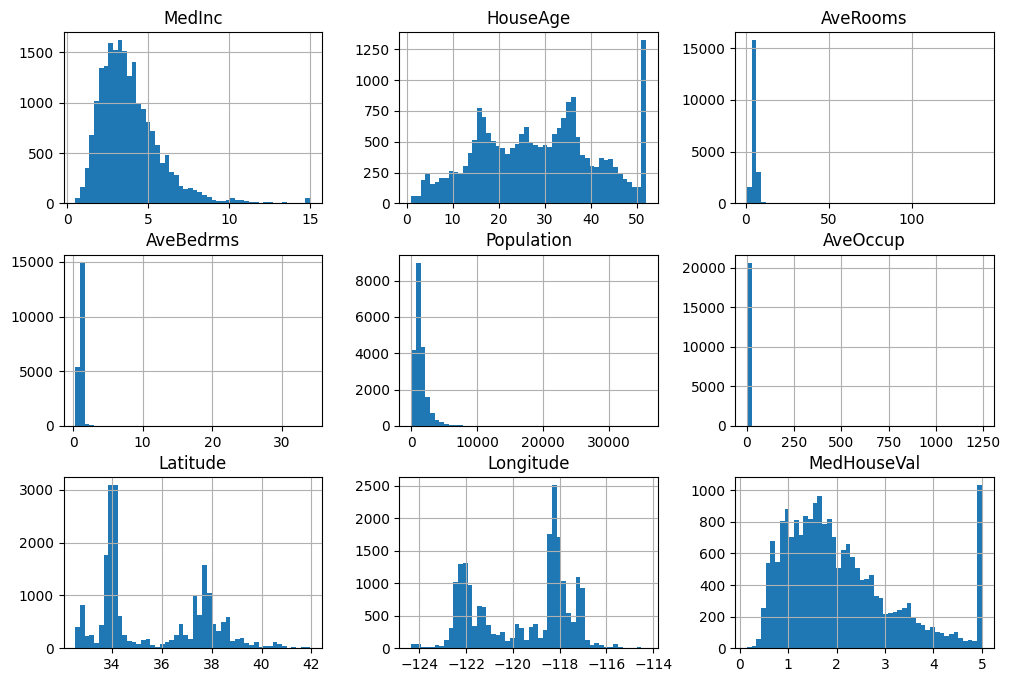

In [6]:
df.head()
df.info()
df.describe()
df.hist(bins=50, figsize=(12, 8))
plt.show()


In [7]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)


In [8]:
housing = train_set.drop("MedHouseVal", axis=1)  # Features
housing_labels = train_set["MedHouseVal"].copy()  # Target


In [9]:
# Numerical + Categorical split
num_features = housing.select_dtypes(include=[np.number]).columns.tolist()
cat_features = []  # No categorical in California housing, but show placeholder

# Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features)
])


In [10]:
housing_prepared = full_pipeline.fit_transform(housing)


In [19]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [20]:
df["income_cat"] = pd.cut(
    df["MedInc"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)


In [21]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# Remove the income_cat column (no longer needed)
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)



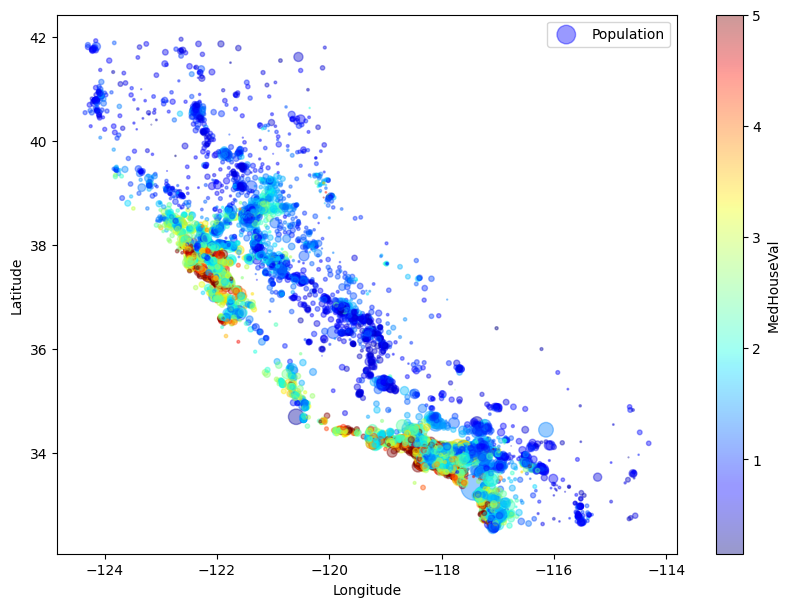

In [22]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
             s=housing["Population"]/100, label="Population", figsize=(10, 7),
             c="MedHouseVal", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()


In [23]:
housing = strat_train_set.drop("MedHouseVal", axis=1)
housing_labels = strat_train_set["MedHouseVal"].copy()


In [28]:
param_grid = [
    {'n_estimators': [30, 50], 'max_features': [6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [30, 50], 'max_features': [6, 8]},
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_features': 6, 'n_estimators': 50}
